# Dispersion Event Search

Following the research of Lockwood et al, we define the Eic paramater of a flux distribution as the energy under the energy of peak flux, whose flux is equal to 10% of the peak.

To search for dispersion events, we measure graduaual $\Delta$Eic in the correct direction when physical parameters are in range. This is done by defining a function $D(t)$ that is integrated over a window of time. If $\int_{tf}^{ti}D(t) dt > \mathrm{threshold}$ (respresenting net change in Eic over the window) and $\int_{t_i}^{t_f}{D(t)dt} > 0.8 \int_{t_i}^{t_f}{|D(t)|dt}$ (representing the majority of the instantaneous change is in the correct direction for dispersion), the window is accepted as being part of a dispersion event. At the end of the algorithm, overlapping windows are merged together.

Definition of the integrand $D(t)$ is as follows. The change in magnetic latitude is utilized to retain a positive sign when the change is in the correct direction, regardless of whether the satellite is traveling northward/southward or is coming from above/below the event.

Search for:

$\Large{\int_{t_i}^{t_f}{D(t)dt}} > \mathrm{threshold}$

and:

$\Large{\int_{t_i}^{t_f}{D(t)dt}} > 0.8 \Large{\int_{t_i}^{t_f}{|D(t)|dt}}$


Where..

$\Large{D(t) = -\mathrm{sgn}(\frac{d|\phi|}{dt})a(t)b(t)\frac{dEic}{dt}}$

and

$
a(t) =   \left\{
\begin{array}{ll}
      1 & \mathrm{Density} > \mathrm{threshold} \\
      0 & \mathrm{Otherwise} \\
\end{array} 
\right. 
$

$
b(t) =   \left\{
\begin{array}{ll}
      1 & \mathrm{Peak\ Flux\ at\ Eic} > \mathrm{threshold} \\
      0 & \mathrm{Otherwise} \\
\end{array} 
\right. 
$

In [1]:
import progressbar
import h5py
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import pytz
import warnings
import pylab as plt
%matplotlib inline
from matplotlib.colors import LogNorm

import search_dispersion_events 
import importlib
importlib.reload(search_dispersion_events)

<module 'search_dispersion_events' from '/mnt/c/Users/dedasilv/OneDrive - NASA/Desktop/dmsp_data/search_dispersion_events.py'>

In [99]:
df = pd.read_csv('data/train.csv', parse_dates=['start_time', 'end_time'])
df.head()

,class,filename,sat,date,start_time,end_time
0,0,data/2015/12/21/dms_20151221_16e.001.hdf5,16,2015-12-21,2015-12-21 09:16:00+00:00,2015-12-21 09:18:00+00:00
1,1,data/2015/12/20/dms_20151220_19e.001.hdf5,19,2015-12-20,2015-12-20 04:05:00+00:00,2015-12-20 04:07:00+00:00
2,0,data/2015/03/17/dms_20150317_18e.001.hdf5,18,2015-03-17,2015-03-17 11:13:00+00:00,2015-03-17 11:18:00+00:00
3,0,data/2011/08/06/dms_20110806_16e.001.hdf5,16,2011-08-06,2011-08-06 11:02:00+00:00,2011-08-06 11:06:00+00:00
4,0,data/2015/12/20/dms_20151220_18e.001.hdf5,18,2015-12-20,2015-12-20 05:56:00+00:00,2015-12-20 05:58:00+00:00


In [97]:

def search(row, plot=True):
    importlib.reload(search_dispersion_events)
    
    # Do computation --------------------------------------------------
    fh = search_dispersion_events.read_file(row.filename)

    dEicdt_smooth, Eic = search_dispersion_events.estimate_log_Eic_smooth_derivative(fh)

    df_match, integrand, integral, upper_area_frac = search_dispersion_events.walk_and_integrate(
        fh, dEicdt_smooth, Eic, search_dispersion_events.DEFAULT_INTERVAL_LENGTH,
        return_integrand=True
    )
    
    if not plot:
        return df_match

    # Do plotting --------------------------------------------------
    for _, row_match in df_match.iterrows():
        i = fh['t'].searchsorted(row_match.start_time)
        j = fh['t'].searchsorted(row_match.end_time)

        fig, axes = plt.subplots(2, 1, figsize=(18, 6), sharex=True)

        im = axes[0].pcolor(fh['t'][i:j], np.log10(fh['ch_energy']), fh['ion_d_ener'][:, i:j], 
                            norm=LogNorm(vmin=1e3, vmax=1e8), cmap='jet')
        plt.colorbar(im, ax=axes[0]).set_label('Log Energy Flux')
        plt.colorbar(im, ax=axes[1]).set_label('')

        axes[0].plot(fh['t'][i:j], Eic[i:j], 'b*-')
        axes[0].invert_yaxis()
        axes[0].set_ylabel('Log Energy [eV] - Ions')

        time_length = row_match.end_time - row_match.start_time
        fig.suptitle(f'{time_length.total_seconds() / 60:.1f} minutes : '
                     f'{row_match.start_time.isoformat()} - {row_match.end_time.isoformat()}', fontweight='bold')
        
        title = 'MLAT = (%.1f deg to %.1f deg)' % (fh['mlat'][i], fh['mlat'][j])
        title += ' Northward' if fh['mlat'][j] > fh['mlat'][i] else ' Southward'
        title += f' -- Integral {float(integral[i:j].max()):.2f} -- UpperFrac {float(upper_area_frac[i]):.2f}'
        axes[0].set_title(title)

        axes[1].fill_between(fh['t'][i:j], 0, integrand[i:j])
        axes[1].axhline(0, color='black', linestyle='dashed')
        axes[1].set_ylim([-.25, .25])
        axes[1].set_ylabel('D(t) [eV/s]')
        
        if row.start_time > row_match.start_time and row.start_time < row_match.end_time:
            axes[1].axvspan(row_match.start_time, row_match.end_time, color='gray', alpha=0.3)
            
    return df_match

N/A% (0 of 86388) |                      | Elapsed Time: 0:00:00 ETA:  --:--:--/mnt/c/Users/dedasilv/OneDrive - NASA/Desktop/dmsp_data/search_dispersion_events.py:241: RuntimeWarning: invalid value encountered in greater
  mlat_direction = -np.sign(np.diff(np.abs(mlat)))
100% (86388 of 86388) |##################| Elapsed Time: 0:00:06 Time:  0:00:06
/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


,start_time,end_time,integral_min,integral_mean,integral_max,integrand_min,integrand_mean,integrand_max
0,2015-12-21 00:43:18+00:00,2015-12-21 00:45:55+00:00,0.666691,1.241407,2.178279,-0.018199,0.021041,0.105999
1,2015-12-21 01:34:21+00:00,2015-12-21 01:35:39+00:00,1.181467,1.404587,1.575062,-0.072674,0.023807,0.136278
2,2015-12-21 01:48:53+00:00,2015-12-21 01:50:11+00:00,0.636368,1.217566,1.369642,-0.084830,0.020637,0.175724
3,2015-12-21 02:26:50+00:00,2015-12-21 02:29:07+00:00,0.603340,1.301803,1.737008,-0.042412,0.022064,0.090869
4,2015-12-21 02:39:43+00:00,2015-12-21 02:41:24+00:00,0.923666,1.090009,1.320234,-0.048461,0.019141,0.075704
5,2015-12-21 03:19:37+00:00,2015-12-21 03:20:43+00:00,1.002769,1.025243,1.045139,-0.045454,0.017377,0.081757
6,2015-12-21 03:21:55+00:00,2015-12-21 03:23:01+00:00,0.611824,0.729568,0.820827,-0.033339,0.012366,0.103024
7,2015-12-21 04:09:32+00:00,2015-12-21 04:11:41+00:00,0.616991,1.671589,2.161736,-0.012153,0.028332,0.136303
8,2015-12-21 05:52:55+00:00,2015-12-21 05:54:37+00:00,0.603512,0.720225,0.899053,-0.011919,0.012207,0.033344
9,2015-12-21 06:59:18+00:00,2015-12-21 07:00:33+00:00,1.030032,1.541248,1.820681,-0.075653,0.026123,0.106004


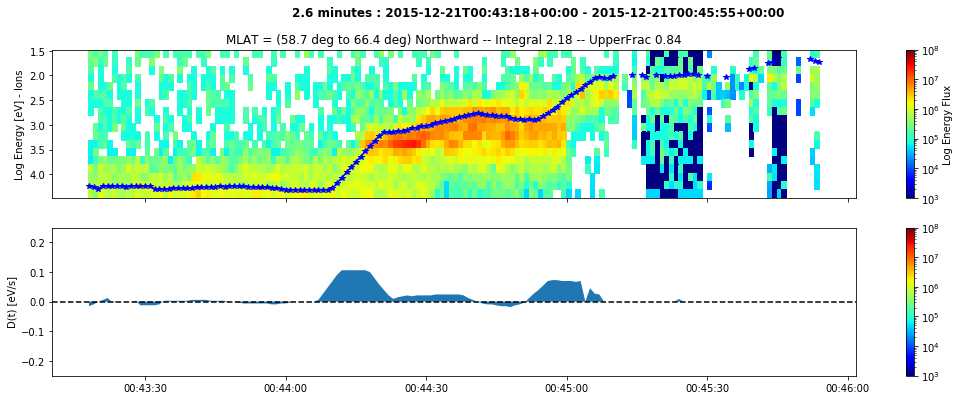

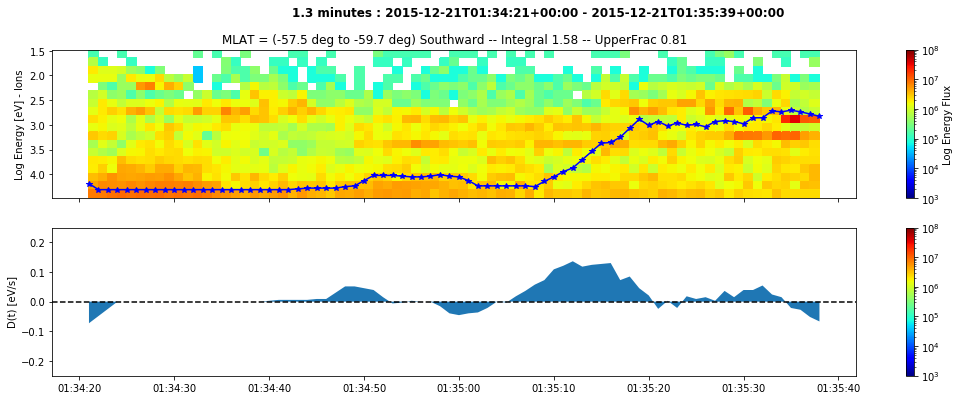

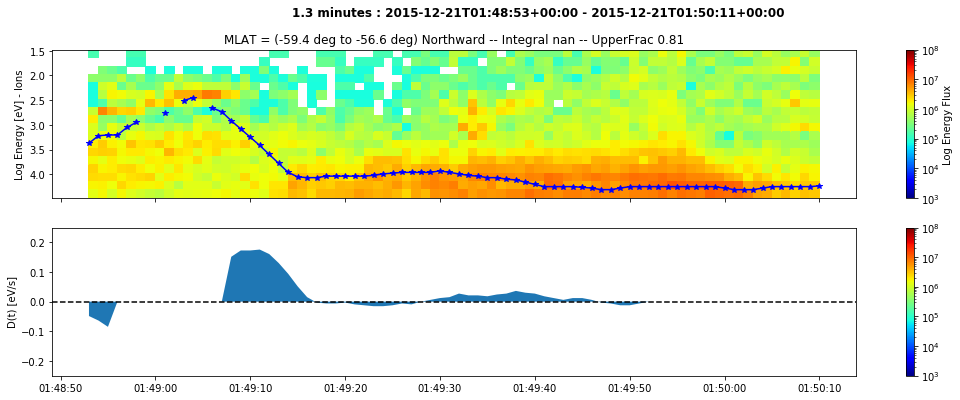

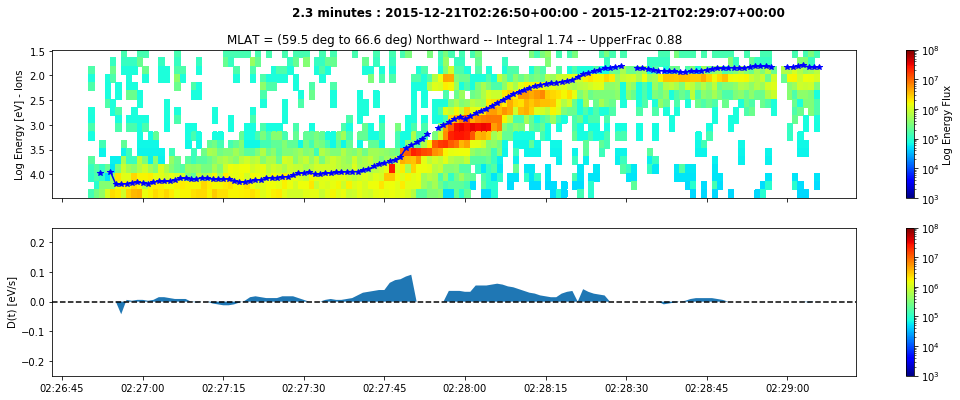

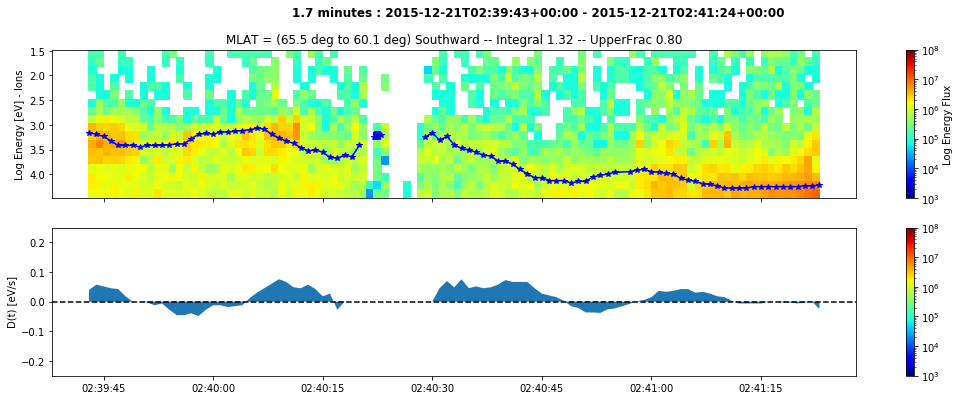

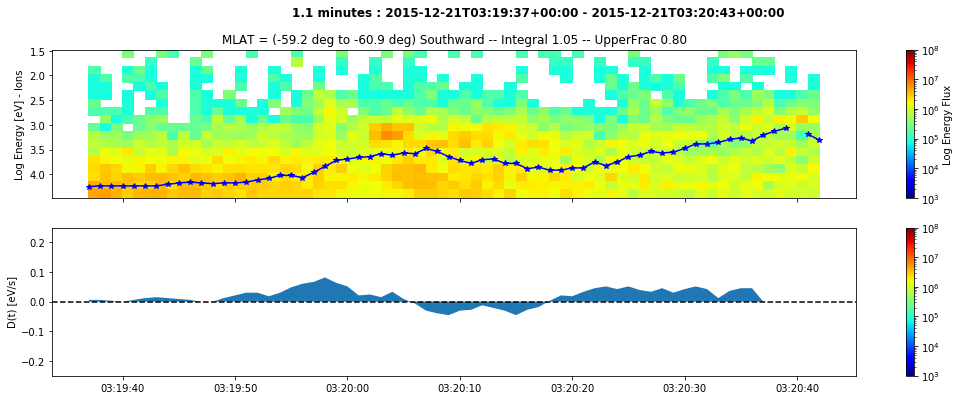

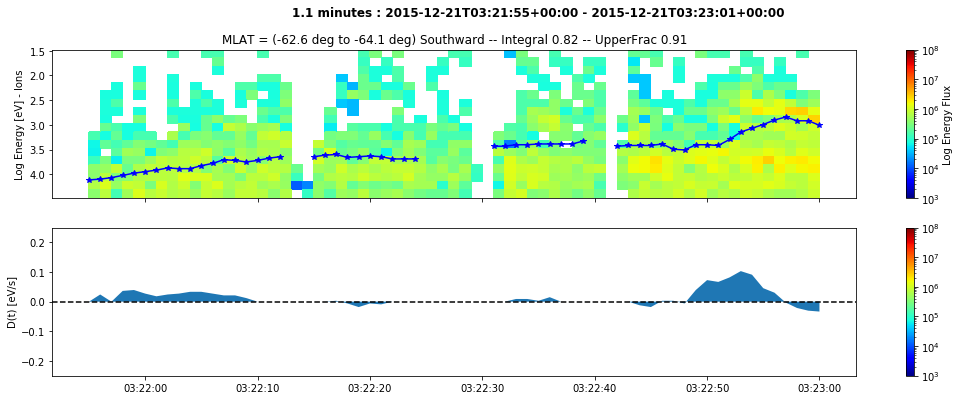

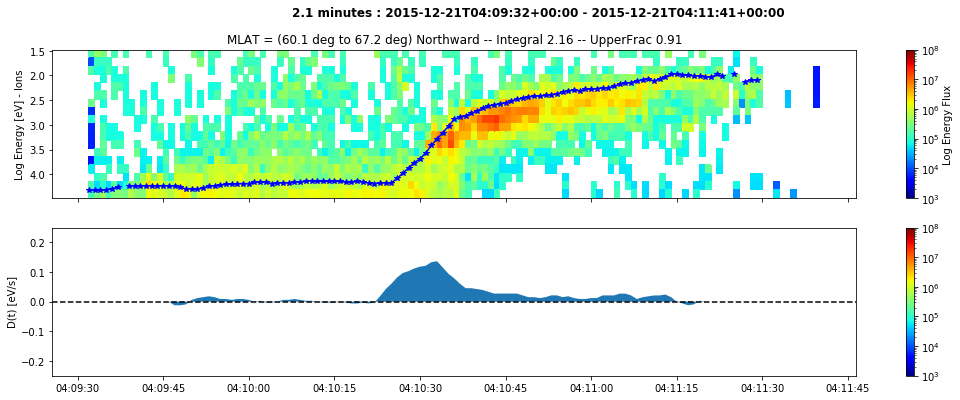

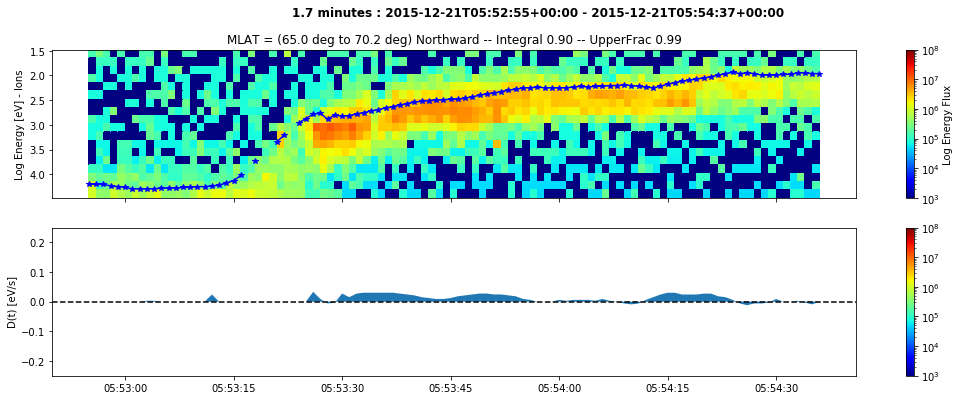

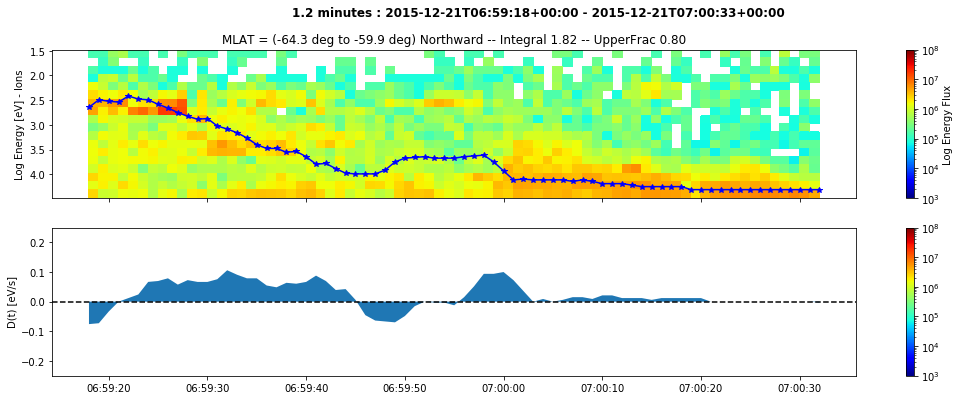

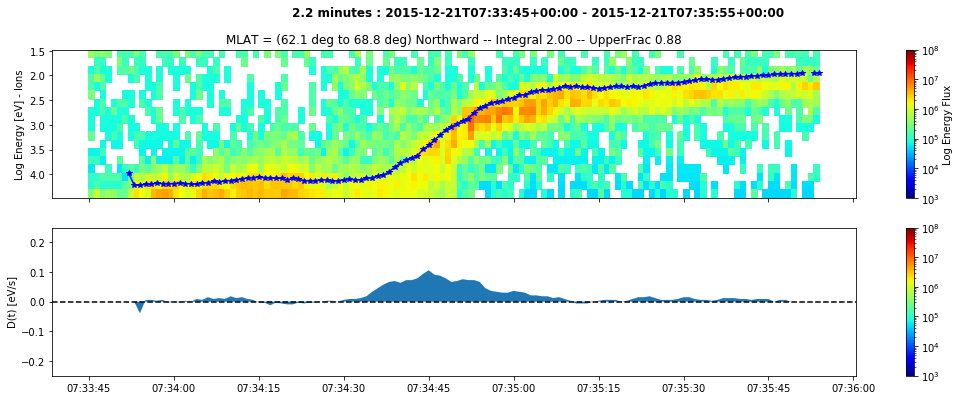

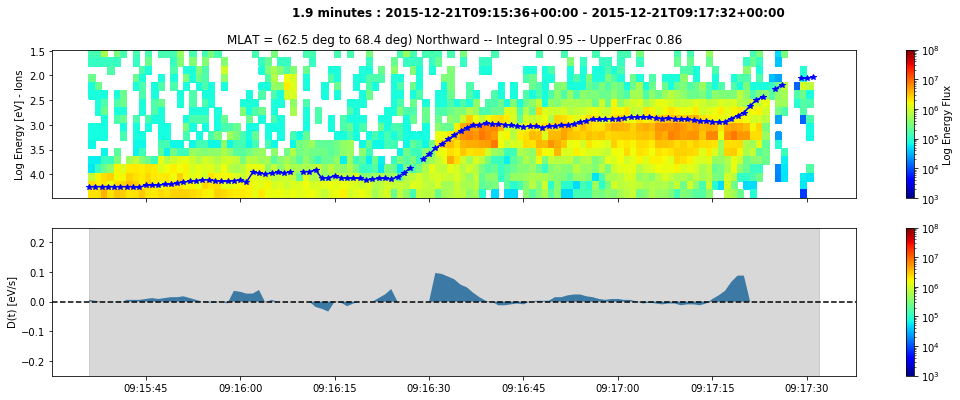

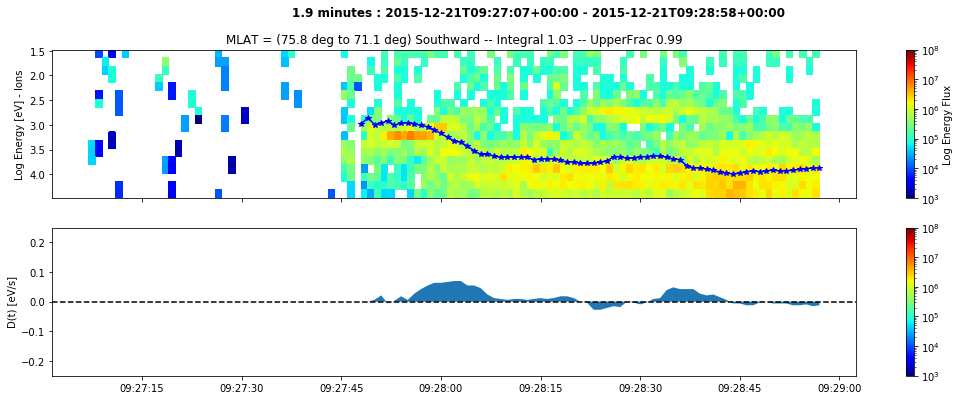

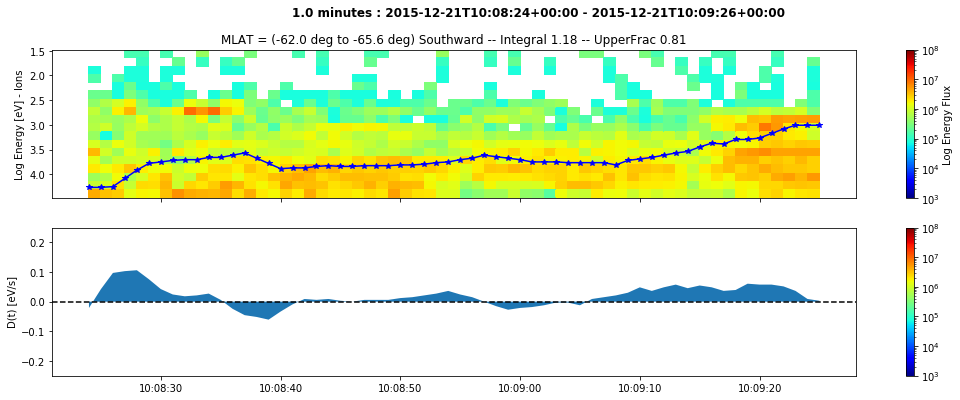

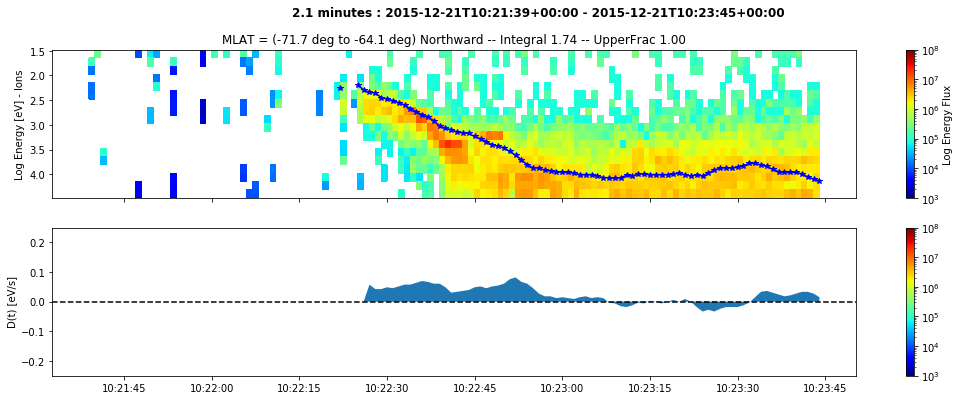

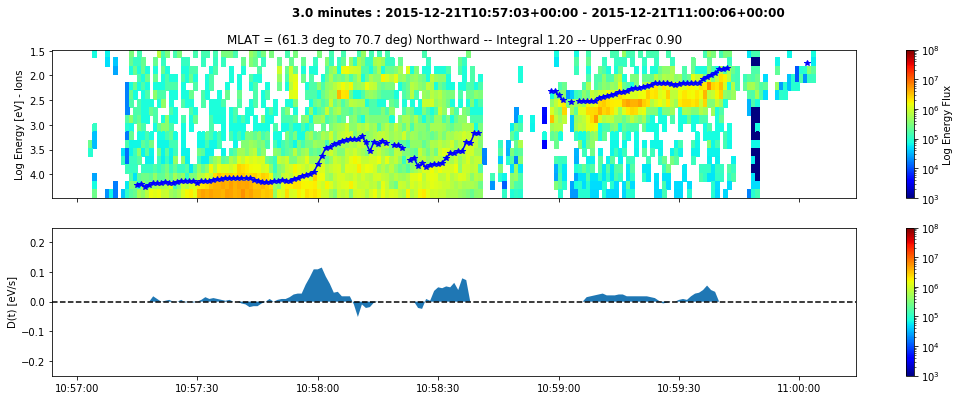

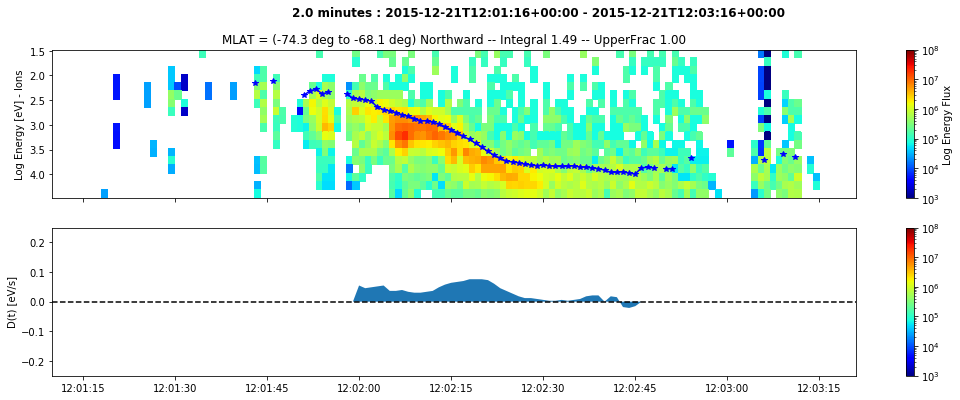

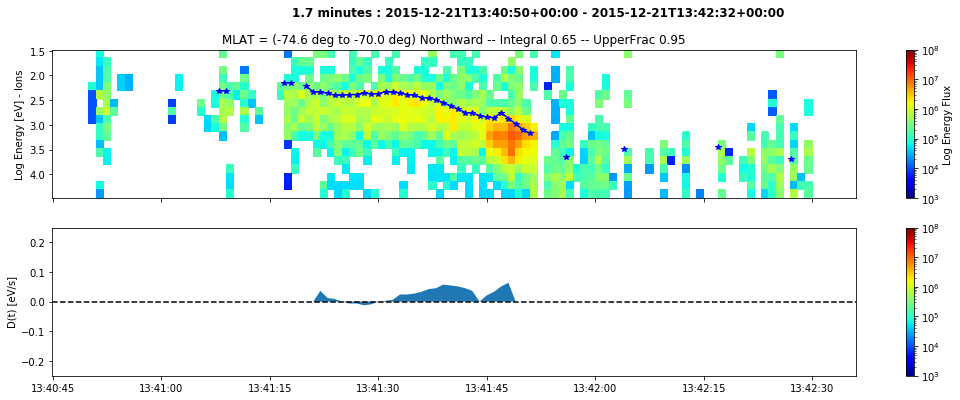

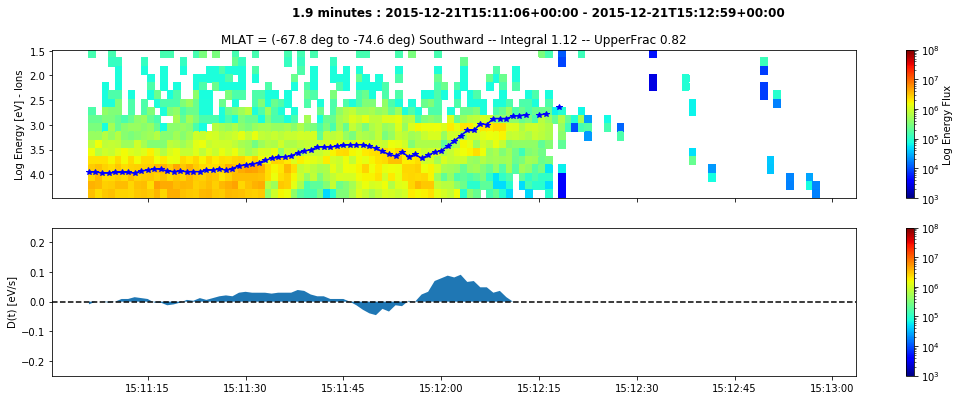

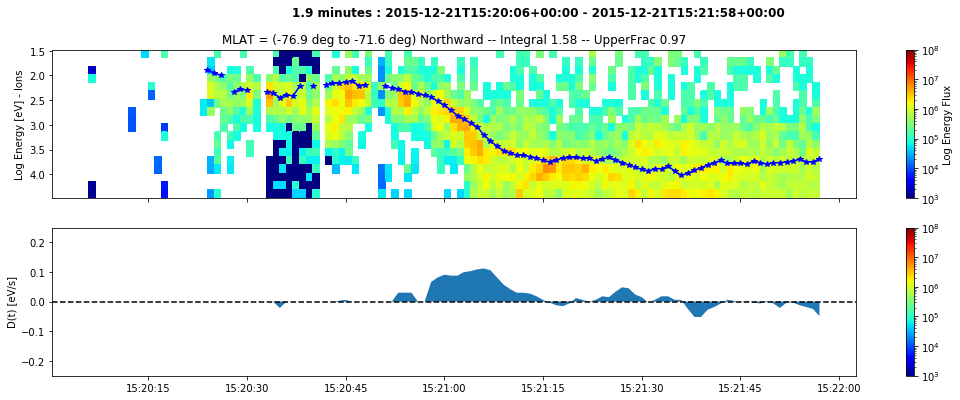

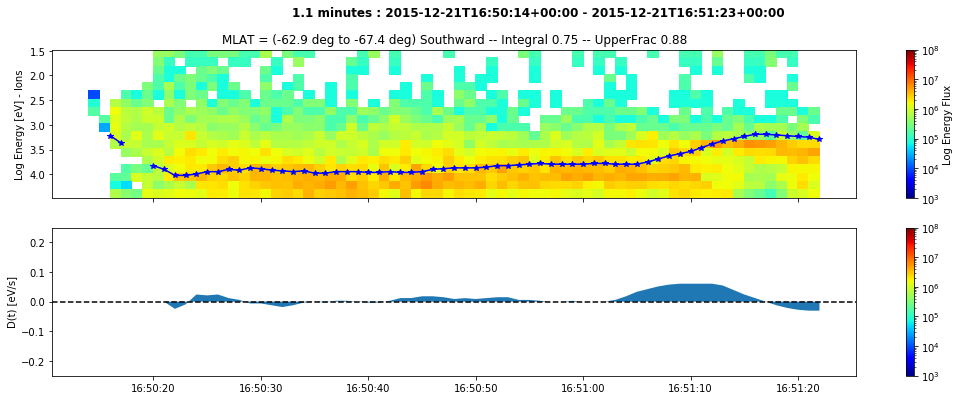

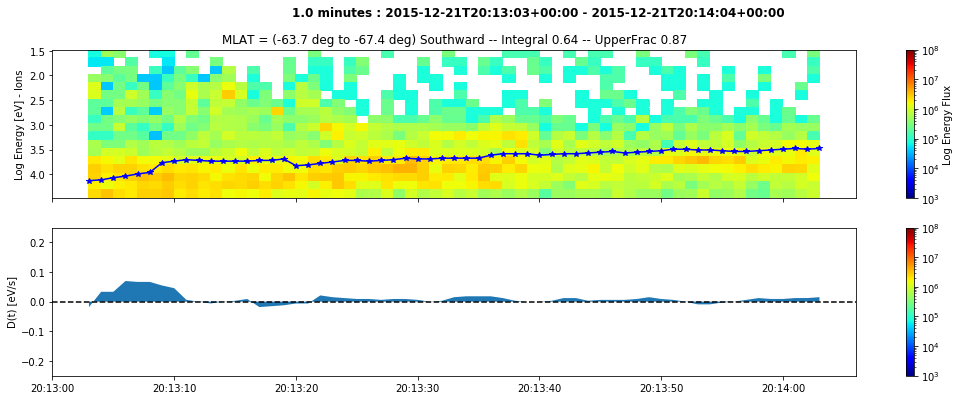

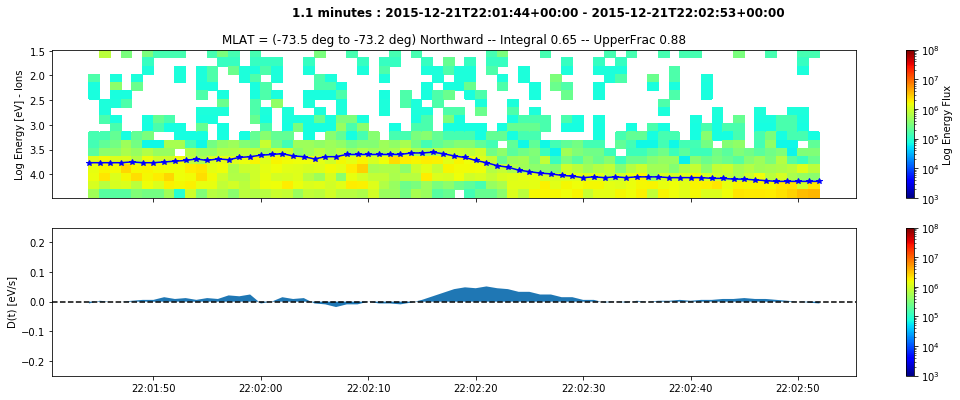

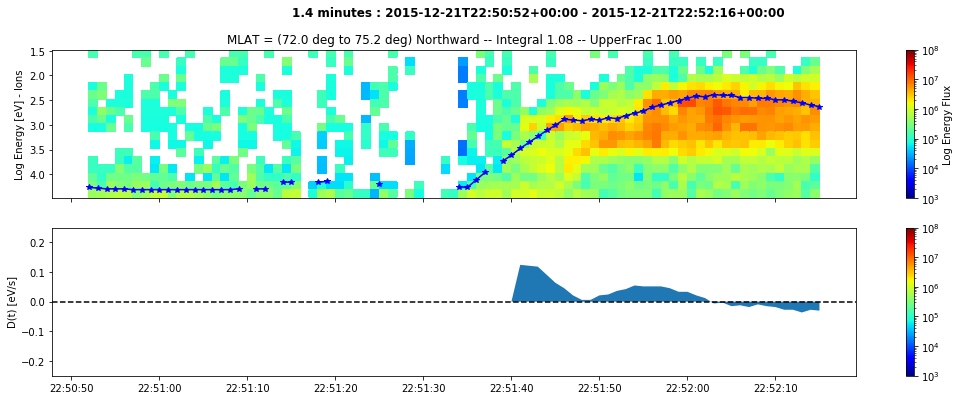

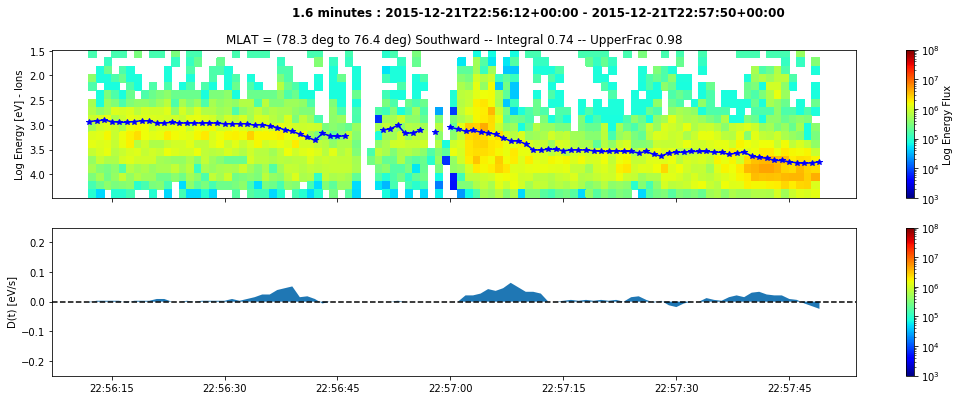

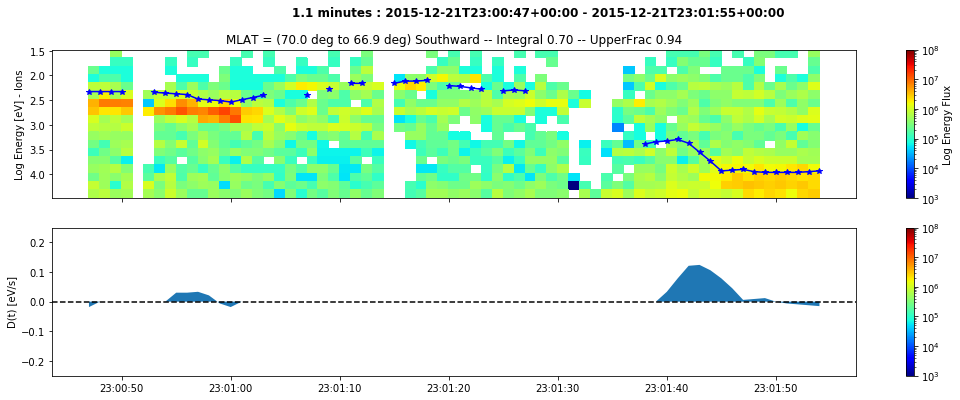

In [98]:
search(df.iloc[0])

# Check Provided Examples exist in Matches for their Respective Day

In [92]:
import joblib

def test(row):
    df_match = search(row, plot=False)
    b=False
    for _, match in df_match.iterrows():
        x1, x2 = row.start_time, row.end_time
        y1, y2 = match.start_time, match.end_time
        
        if x1 <= y2 and y1 <= x2:
            b=True
            break    
    return (row, b)

In [93]:
from joblib import Parallel, delayed
results = Parallel(n_jobs=12)(delayed(test)(row) for _, row in df[df['class']==1].iterrows())

/home/daniel/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [104]:
correct_fraction = sum(1 for (row, b) in results if b)/len(results)
print('Correctly classified the following fraction of provided examples:')
print(f'{correct_fraction:.2f}')

Correctly classified the following fraction of provided examples:
0.81


In [103]:
print('Provided examples not detected:')
print([row.name for row, b in results if not b])

Provided examples not detected:
[50, 79, 123, 146, 165, 167, 194, 200, 201, 203, 218, 220, 225, 228, 238, 246, 266, 295, 301, 304]
